In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("TF version:", tf.__version__)


TF version: 2.15.1


In [8]:
df = pd.read_csv("bs140513_032310.csv")

print("Shape:", df.shape)
display(df.head())
print("\nKolom:", df.columns.tolist())

print("\nMissing values (top 15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

if "fraud" not in df.columns:
    raise ValueError("Kolom target 'fraud' tidak ditemukan di dataset.")
    
print("\nDistribusi target fraud:")
display(df["fraud"].value_counts())
display((df["fraud"].value_counts(normalize=True) * 100).rename("percent"))


Shape: (594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0



Kolom: ['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category', 'amount', 'fraud']

Missing values (top 15):


step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


Distribusi target fraud:


fraud
0    587443
1      7200
Name: count, dtype: int64

fraud
0    98.789189
1     1.210811
Name: percent, dtype: float64

In [9]:
y = df["fraud"].astype(int)
X = df.drop(columns=["fraud"]).copy()

# DROP fitur yang bikin one-hot meledak (ribuan kategori)
for col in ["customer", "merchant"]:
    if col in X.columns:
        X.drop(columns=[col], inplace=True)

print("Kolom X yang dipakai:", X.columns.tolist())


Kolom X yang dipakai: ['step', 'age', 'gender', 'zipcodeOri', 'zipMerchant', 'category', 'amount']


In [11]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Imputasi (WAJIB)
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_num = pd.DataFrame(num_imputer.fit_transform(X[num_cols]), columns=num_cols) if num_cols else pd.DataFrame(index=X.index)
X_cat = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols) if cat_cols else pd.DataFrame(index=X.index)

# One-Hot Encoding (WAJIB)
X_cat_oh = pd.get_dummies(X_cat, columns=cat_cols, drop_first=False) if cat_cols else pd.DataFrame(index=X.index)

X_all = pd.concat([X_num, X_cat_oh], axis=1)

print("X_all shape:", X_all.shape)
print("Ada NaN di X_all?", X_all.isna().any().any())
print("Tipe data (harus numerik semua):")
display(X_all.dtypes.value_counts())


Numeric cols: ['step', 'amount']
Categorical cols: ['age', 'gender', 'zipcodeOri', 'zipMerchant', 'category']
X_all shape: (594643, 31)
Ada NaN di X_all? False
Tipe data (harus numerik semua):


bool       29
float64     2
Name: count, dtype: int64

In [12]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_all, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test  = scaler.transform(X_test_df)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)
print("Fraud ratio train:", y_train.mean())
print("Fraud ratio test :", y_test.mean())


Train shape: (475714, 31)
Test shape : (118929, 31)
Fraud ratio train: 0.012108115380249477
Fraud ratio test : 0.012108064475443332


In [13]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
class_weight


{0: 0.5061282593615546, 1: 41.29461805555555}

In [14]:
input_dim = X_train.shape[1]

model = Sequential([
    Dense(8, activation="relu", input_shape=(input_dim,)),
    Dense(4, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")   # Klasifikasi biner
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 256       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 297 (1.16 KB)
Trainable params: 297 (1.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # Validation set otomatis (WAJIB)
    epochs=100,
    batch_size=32,
    callbacks=[early],
    class_weight=class_weight,  # boleh hapus jika diminta dosen
    verbose=1
)


Epoch 1/100
11893/11893 [==============================] - 52s 2ms/step - loss: 0.1343 - accuracy: 0.9169 - val_loss: 0.1289 - val_accuracy: 0.9297
Epoch 2/100
11893/11893 [==============================] - 20s 2ms/step - loss: 0.1278 - accuracy: 0.9202 - val_loss: 0.1297 - val_accuracy: 0.9269
Epoch 3/100
11893/11893 [==============================] - 20s 2ms/step - loss: 0.1264 - accuracy: 0.9200 - val_loss: 0.1291 - val_accuracy: 0.9229
Epoch 4/100
11893/11893 [==============================] - 21s 2ms/step - loss: 0.1229 - accuracy: 0.9216 - val_loss: 0.1438 - val_accuracy: 0.9173
Epoch 5/100
11893/11893 [==============================] - 20s 2ms/step - loss: 0.1225 - accuracy: 0.9205 - val_loss: 0.1262 - val_accuracy: 0.9230
Epoch 6/100
11893/11893 [==============================] - 20s 2ms/step - loss: 0.1246 - accuracy: 0.9207 - val_loss: 0.1379 - val_accuracy: 0.9204
Epoch 7/100
11893/11893 [==============================] - 23s 2ms/step - loss: 0.1257 - accuracy: 0.9192 - val_

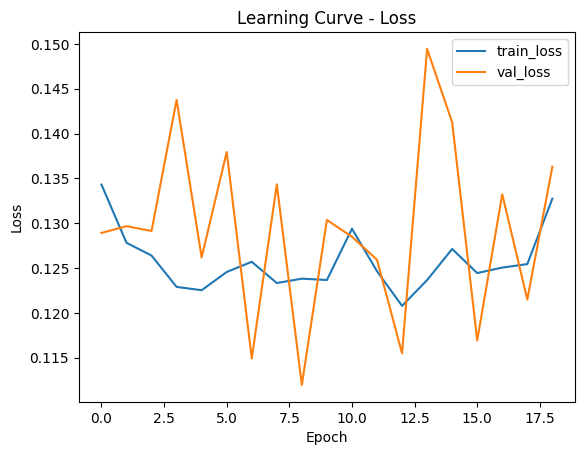

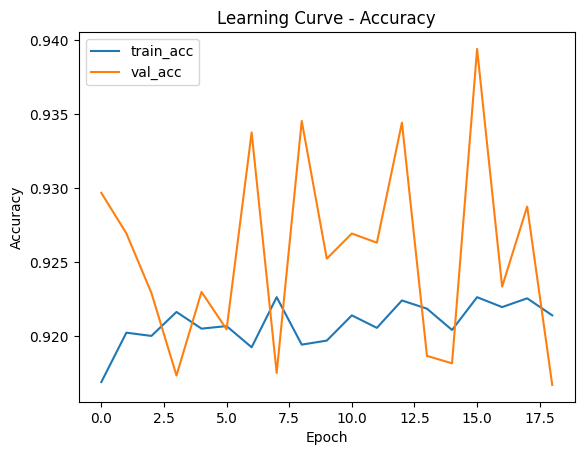

Analisis cepat:
- Jika train_loss turun tapi val_loss naik -> overfitting.
- Jika train_acc sangat tinggi tapi val_acc rendah -> overfitting.
- Jika keduanya rendah dan stagnan -> underfitting.


In [17]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend(); plt.show()

print("Analisis cepat:")
print("- Jika train_loss turun tapi val_loss naik -> overfitting.")
print("- Jika train_acc sangat tinggi tapi val_acc rendah -> overfitting.")
print("- Jika keduanya rendah dan stagnan -> underfitting.")


In [18]:
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))


3717/3717 [==============================] - 4s 1ms/step
Confusion Matrix:
 [[109788   7701]
 [    35   1405]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9345    0.9660    117489
           1     0.1543    0.9757    0.2665      1440

    accuracy                         0.9350    118929
   macro avg     0.5770    0.9551    0.6162    118929
weighted avg     0.9894    0.9350    0.9575    118929



In [19]:
import joblib, json

model.save("model.keras")
joblib.dump(num_imputer, "num_imputer.joblib")
joblib.dump(cat_imputer, "cat_imputer.joblib")
joblib.dump(scaler, "scaler.joblib")

meta = {
    "dropped_cols": ["customer", "merchant"],
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "feature_columns": X_all.columns.tolist(),
    "threshold": 0.5
}
with open("meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved: model.keras, num_imputer.joblib, cat_imputer.joblib, scaler.joblib, meta.json")


Saved: model.keras, num_imputer.joblib, cat_imputer.joblib, scaler.joblib, meta.json
